# Introduction to Neural Networks

-----

## CHANGE SVM TO NN

In this notebook, we introduce the [Support Vector Machine (SVM) algorithm][svm], a powerful, but simple supervised learning approach to predicting data. For classification tasks, the SVM algorithm attempts to divide data in the feature space into distinct categories. By default, this division is performed by constructing hyperplanes that optimally divide the data. For regression, the hyperplanes are constructed to map the distribution of data. In both cases, these hyperplanes map linear structures in a non-probabilistic manner. By employing a _kernel trick_, however, we can transform non-linear data sets into linear ones, thus enabling SVM to be applied to non-linear problems.

SVMs are powerful algorithms that have gained widespread popularity. This is partly due to the fact that they are effective in high dimensional feature spaces, including those problems where the number of features is similar to or slightly exceeds the number of instances. They can also be memory efficient since only the support vectors are needed to compute the hyperplanes. Finally, by using different kernels, SVM can be applied to a wide range of learning tasks. On the other hand, these models are black boxes, and it can be difficult to explain how they operate, especially on new instances. They do not, by default, provide probability estimates since the hyperplane is constructed to cleanly divide the training data.

In this notebook, we first explore the basic formalism of the SVM algorithm, including the construction of hyperplanes and the kernel trick, which enables SVM to be applied to non-linear problems. Next, we explore the application of SVM to classification problems, which is known as support vector classification, or SVC. To introduce this topic, we will once again use the Iris data to construct an SVC estimator, explore the resulting performance and decision surface, before looking at the effect of different hyperparameter values. Next, we will switch to a more complex data set, the adult data demonstrated in the Introduction to Decision Tree notebook, with which we will explore unbalanced classes and more advanced classification performance metrics such as the ROC, AUC, and Lift curve. Finally, we will apply SVM to regression problems, which is known as support vector regression. For this we will use the automobile miles per gallon regression task first presented in the Introduction to Decision Tree notebook.

-----
[idt]: intro2dt.ipynb
[svm]: https://en.wikipedia.org/wiki/Support_vector_machine

## Table of Contents

[Formalism](#Formalism)

- [Hyperplanes](#Hyperplanes)
- [Non-linear Kernels](#Non-linear-Kernels)

[Support Vector Machine: Classification](#Support-Vector-Machine:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Support Vector Classification: Decision Surface](#Support-Vector-Classification:-Decision-Surface)
- [Support Vector Classification: Hyperparameters](#Support-Vector-Classification:-Hyperparameters)
- [Classification: Adult Data](#Classification:-Adult-Data)
- [Support Vector Classification: Unbalanced Classes](#Support-Vector-Classification:-Unbalanced-Classes)

[The ROC Curve and AUC](#The-ROC-Curve-and-AUC)

[The Gain and Lift Charts](#The-Gain-and-Lift-Charts)

[Support Vector Machine: Regression](#Support-Vector-Machine:-Regression)

- [Regression: Auto MPG Data](#Regression:-Auto-MPG-Data)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----



In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

As was the case with the decision tree, one of the simplest machine learning algorithms to understand and employ is the [support vector machine][svm]. For classification tasks, this algorithm simply divides the data with hyperplanes into the resulting classes, while for regression, the hyperplanes form a predictive model of the underlying data. These hyperplanes, by default, produce a linear classifier (or regressor) since they are restricted to be linear in the features. However, unlike a decision tree, SVM produces a black box model; we can't examine the model, especially in higher dimensions, to understand why specific predictions are made. In order to construct the optimal set of hyperplanes, SVM assumes the features are normalized and can be compared equally. Thus, for proper use of an SVM on a data set, we must normalize the features.

Given a set of data with $n$ features, we can construct many different hyperplanes that divide the data. The SVM algorithm selects the optimal hyperplane by finding the one that produces the largest separation, which is known as the _margin_, between the data. The hyperplane that accomplishes this goal is known as the maximum-margin hyperplane. For high dimensional data, a set of hyperplanes is constructed, which accomplishes this same task. In cases where the data can not be cleanly separated, many SVM implementations map the data set into a higher dimensional space by using a kernel function, where the data are linearly separated and construct a set of optimal hyperplanes in this space. This process can also be used to transform a non-linear feature space into a linear (or approximately linear) space where traditional SVM can be applied.

In the rest of this section, we demonstrate the construction of hyperplanes by using the Iris data set. To simplify the visualization of these data and the resulting hyperplanes, we use only two dimensions. Since SVM, by default, provides a linear classification, these hyperplanes will generate linear divisions between classes. After this, we demonstrate how a kernel can be employed to transform a non-linear problem into a linear classification task.

-----

[svm]: https://en.wikipedia.org/wiki/Support_vector_machine

-----

[[Back to TOC]](#Table-of-Contents)

### Hyperplanes

To demonstrate how hyperplanes can divide data, we will use the standard Iris classification data set. In the following two Code cells, we first use our helper functions to load the Iris data, subdivide into training and testing, and normalize the data by using the training features. Next, we select only two dimensions: Sepal Width and Petal Width, to use in our subsequent analysis to enable easier visualization of the training data, test data, and hyperplanes.

The second Code cell uses the training data to generate an SVC (don't worry about the details of doing this right now, they are introduced in the next section). Next, we make a scatter plot of the training data, colored by their label, and display test data with a different symbol (see the plot legend for full details). Next, we generate a grid of points through this space and apply the predetermined SVC to generate decisions over this grid (note, this is similar to how we construct decisions surfaces for classification tasks). Finally, we plot two of the three computed hyperplanes (the algorithm generates a separate hyperplane to divide between each set of classes, we have three types of Iris, so we have three sets of hyperplanes) and the support vectors used to compute these hyperplanes from the training data.

The hyperplanes shown in the plot are denoted by the solid gray line. We also plot the confidence interval (or upper and lower one-sigma standard deviations) for these hyperplanes, the upper boundary as a blue dashed line, and the lower boundary as a red dashed line. The confidence interval in this case provides an estimate for the uncertainty in the location of the true hyperplane given these training data. 

The support are those training data that are used to finalize the selection of the best hyperplane. The training data that anchor the support vectors are enclosed in a large yellow circle. The vector extends from these points to the hyperplane (forming a right angle to the hyperplane). The margin for each support vector is the distance from the support to the hyperplane (or the length of the support vector). It is the combinations of these distances that we seek to minimize when we compute the best hyperplane. 

-----

In [2]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.4

# Load, but don't plot the data
show_plot = False

d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)
    
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

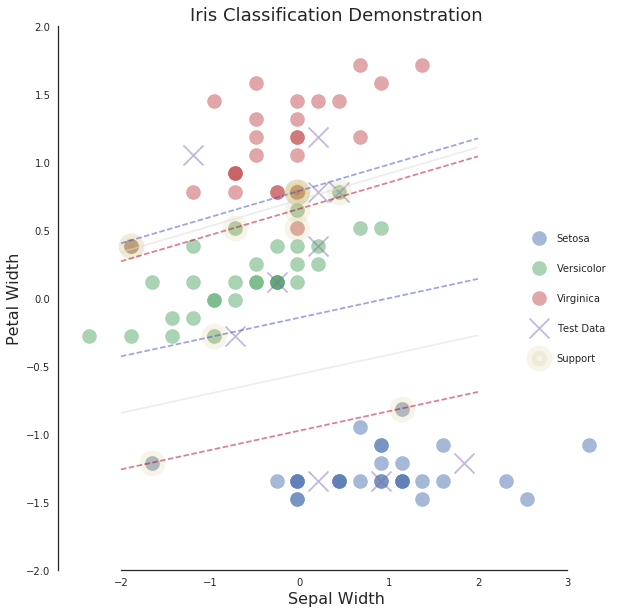

In [3]:
from sklearn.svm import SVC
from matplotlib import cm

# Fit the model, don't regularize for illustration purposes
iris_model = SVC(kernel='linear', C=1E6)
iris_model.fit(n_data[:,:2], n_data[:,2])

# Number of training samples to show in plot
num_show = 10

# Now we create our figure and axes for the plot we will make.
fig, ax = plt.subplots(figsize=(10, 10))
        
# Select features from training data to plot
x = d_train_sc[:, 1]
y = d_train_sc[:, 3]

# Labels for instances
iris_name = ['Setosa', 'Versicolor', 'Virginica']

# Iterate over types of instances, plotting each separately
for idx in np.unique(l_train):
    i = int(idx)
    ax.scatter(x[l_train == i], y[l_train == i], 
               label=f'{iris_name[idx]}',
               s=200, alpha = .5, cmap=cm.coolwarm) 

# Now plot the test data differently
xx = d_test_sc[:num_show, 1]
yy = d_test_sc[:num_show, 3]
ax.scatter(xx, yy, label='Test Data',
           marker='x', s=400, alpha = .5, cmap=cm.coolwarm) 

# Create grid to evaluate model
xx = np.linspace(-2, 2, 30)
yy = np.linspace(-2, 2, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# Predict on this grid
ZZ = iris_model.decision_function(xy)

# Take the grid and construct the hyperplanes 
# by treating them as contours. Note that we only select 
# the first and third hyperplane, otherwise plot becomes
# too busy.
for idx in [0, 2]:
    # Grab out relevant hyperplane data
    z = ZZ[:,idx].reshape(XX.shape)

    # Plot hyperplanes
    ax.contour(XX, YY, z, levels=[-1, 0, 1], 
               alpha=0.5, linewidth=100,linestyles=['--', '-', '--'],
               cmap=cm.coolwarm) 
    
# Plot support vector data points.
ax.scatter(iris_model.support_vectors_[:, 0], 
           iris_model.support_vectors_[:, 1], 
           s=250, linewidth=10, alpha=0.15, cmap=cm.coolwarm,
           label='Support')

# Decorate and clean plot
ax.set_xlabel('Sepal Width', fontsize=16)
ax.set_ylabel('Petal Width', fontsize=16)
ax.legend(loc = 7, labelspacing=2)
ax.set_title("Iris Classification Demonstration", fontsize=18)

sns.despine(offset=0, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)


### Non-Linear Kernels

In many real-world cases, the data of interest are non-linear. In these cases, we can still successfully employ SVM by transforming the data into a space where the data are linearly separated. This process is known as the _kernel trick_, since we employ a kernel function to perform the mapping. To demonstrate this process, the following Code cell generates two classes of data. The first class is enclosed in a circle about the origin, while the second class is contained in a ring that surrounds the first class. 

-----

In [4]:
# Generate random data in polar coordinates
# Then tranform to r, theta as linear. 
# This demonstrates the kernel SVM trick.

# Set random state for reproducability
rng = np.random.RandomState(23)

# Random radial data, two ranges
r1 = rng.uniform(0, 1, 50)
r2 = rng.uniform(1.25, 2.5, 50)

# Random theta uniformly around circle.
t1 = rng.uniform(0, 360, 50)
t2 = rng.uniform(0, 360, 50)

# Transform to Cartesian, which forms
# our new starting data set
x1 = r1 * np.sin(t1)
x2 = r2 * np.sin(t2)
y1 = r1 * np.cos(t1)
y2 = r2 * np.cos(t2)

-----

Given these simulated data, the next Code cell first plots the original data as generated, the first class is blue points, while the second class is green points. Clearly these data are distributed in a non-linear pattern, and a standard SVC would not perform well on this task (a non-linear technique, such as a decision tree would likely perform better, assuming we have sufficient data to generate a tree that effectively captures the non-linear signal without overfitting). 

We can, however, apply a transformation to convert from the original Cartesian coordinate system spanned by the original data to a polar coordinate system, which uses radial distance from the origin as the new `x` axis, and the angle from the original positive x axis as the new `y` axis. In this new space, the data are easily separated by a simple vertical line, and thus an SVC would perform extremely well in this new projection. To effectively apply SVM to data, we must often choose a kernel that will employ this type of transformation, or another, to reliably project data into a new space where the data can be effectively divided by the SVM algorithm.

-----

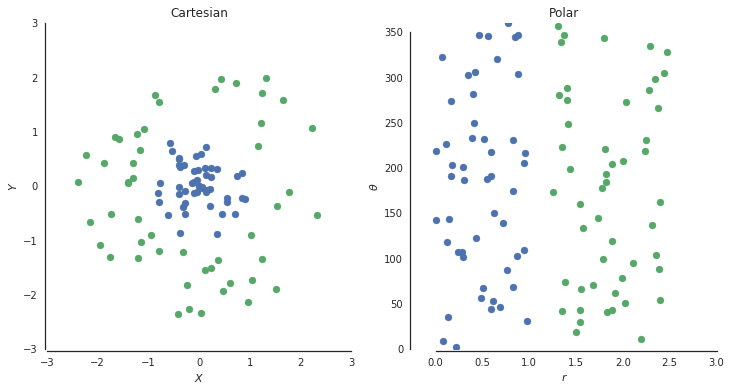

In [5]:
# Two plots, one for polar, one for linear.
fig, axs = plt.subplots(figsize=(12, 6.0), nrows=1, ncols=2, sharex=False)
adj = plt.subplots_adjust(hspace=0.5)

# Plot x,y dat
axs[0].scatter(x1, y1)
axs[0].scatter(x2, y2)
axs[0].set(xlabel=r'$X$', xlim=(-3, 3),
           ylabel=r'$Y$', ylim=(-3, 3),
           title='Cartesian')

# Plot, r, theta
axs[1].scatter(r1, t1)
axs[1].scatter(r2, t2)
axs[1].set(xlabel=r'$r$', xlim=(-0.25, 3),
           ylabel=r'$\theta$', ylim=(0, 360),
           title='Polar')

# Clean plots
sns.despine(offset = 2, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)


## Support Vector Classification

With a discussion on the construction of hyperplanes complete, we can now introduce how to perform [support vector classification][sksvc] by using the scikit-learn library. This is accomplished by using the `SVC` estimator, which is located in the `svm` module. To perform linear SVC, we must specify that we wish to use a `linear` kernel as a hyperparameter, note this is not the default option. We could, instead, use the `LinearSVC` estimator, which does not support a kernel hyperparameter, and can only be used for linear classification problems.

The `SVC` estimator accepts a number of hyperparameters that control how it performs, some of the more useful hyperparameters include:

- `kernel`: controls the kernel used to transform the data into a (quasi-)linear space. Options include `linear`, `rbf` for radial basis function, similar to the transformation displayed earlier in this notebook, `poly` for polynomial, `sigmoid` for a transformation similar to that used by the logistic function, or a user defined function, which can also be pre-computed.
- `C`: penalty term for regularization, setting this high reduces the effects of regularization.
- `class_weight`: determines how unbalanced classes are handled, by default, weights are assumed to be uniform. Specifying the value of `balanced` for this hyperparameter indicates that weights should be determined automatically from the training data. 
- `decision_function_shape`: determines if multi-class problems return a decision function that is computed as a _one-versus-rest_, the recommended, or a _one-versus-one_, where each pair of classes is divided separately.
- `random_state`: seed for random number generation, setting this ensures reproducibility.

To demonstrate how to use SVC, we will use the previously loaded Iris data set (which we did to construct and visualize hyperplanes). With these data, we will create an SVC estimator that employs a linear kernel with a defined random seed. Next, we fit this estimator to our training data, and produce an accuracy metric. As the following Code cell demonstrates, our straightforward application of an SVC to these data generates a very robust prediction. The two Code cells that follow the first display the classification report and confusion matrix for this prediction task, which once again indicates that the SVC has performed very well on these data.

-----

[sksvc]: http://scikit-learn.org/stable/modules/svm.html#svm-classification

In [6]:
# Next lets try SVM
from sklearn.svm import SVC

# Use default parameters, except we want a linear kernel
# and we specify the random_state hyperparameter to 
# ensure reproduceability.
svc = SVC(kernel='linear', random_state=23)
svc = svc.fit(d_train_sc, l_train)

#z = svc.predict(mdata)

#hi.splot_data(data, mdata, z, 'First Component', 'Second Component', 50)

# Compute and display accuracy score
score = 100.0 * svc.score(d_test_sc, l_test)
print(f"SVM prediction accuracy = {score:5.1f}%")

SVM prediction accuracy =  98.3%


In [7]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = svc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        21
 Versicolor       0.95      1.00      0.97        18
  Virginica       1.00      0.95      0.98        21

avg / total       0.98      0.98      0.98        60



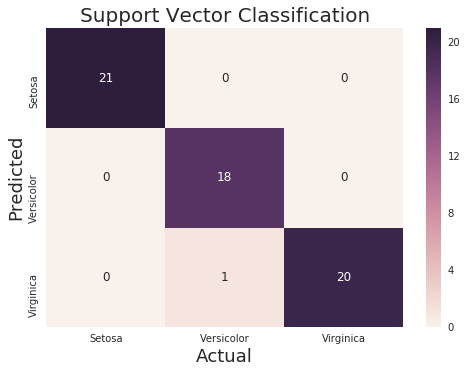

In [8]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Support Vector Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### SVM:  Decision Surface

The SVC we constructed for the Iris data employed a linear kernel, thus we expect the hyperplanes to create linear divisions in our data. To explore the nature of the hyperplanes constructed for our Iris training data, we construct and display a decision surface in the following Code cell for our Iris data. In this case, we must restrict our data (and model) to two dimensions: Sepal Width and Petal Width. 

The visualization displays both the training data and the decision surface, which clearly shows linear splits between the three classes. Note that the linear split is not parallel to the axes, instead it is a linear combination of these features, which produces a linear division that best separates the data. For these data, we only have one misclassification, which is quite good, but most data sets are not this cleanly divisible. In the next code cell, we explore how changing the `kernel` hyperparameter will affect the decision surface.

-----

SVM (Kernel=linear) accuracy =  96.7%


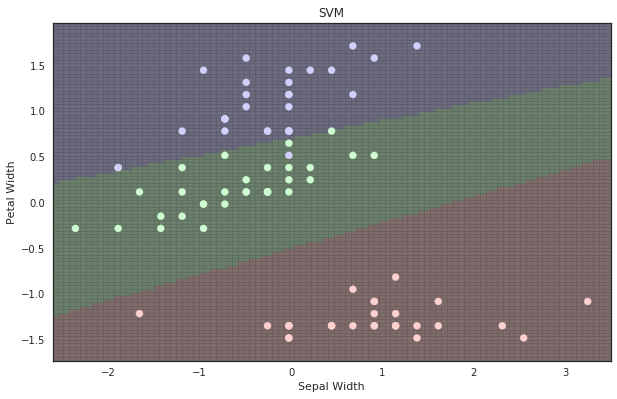

In [9]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)
t_data = hi.trim_data(d_test_sc, l_test)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
svc.fit(n_data[:,:2], n_data[:,2])
    
# Compute and display accuracy score
score = 100.0 * svc.score(t_data[:,:2], t_data[:,2])
print(f"SVM (Kernel=linear) accuracy = {score:5.1f}%")    

# Predict for mesh grid
z = svc.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)

# Provide title for plot, the trailing semicolon
# is used to prevent the printing of the plot object details
ax.set_title(f'SVM') ;

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding Code cells, we used a simple linear SVC to predict classifications for the Iris data. Now that you have run the notebook once, go back and make the following changes to see how the results change.

1. Change the training to testing split size, for example change from a 60%:40% to a 75%:25%, and to a 50%:50%.
2. Change the random_state hyperparameter in the SVM algorithm.

Finally, how does the decision surface compare to the decision surface computed for the k-nn classification algorithm, or to that from the decision tree classification algorithm?

-----

-----

[[Back to TOC]](#Table-of-Contents)

### SVM: Hyperparameters

Perhaps the most important hyperparameter for SVC is the `kernel` hyperparameter, which specifies the type of transformation that should be applied to the training data to determine the optimal set of hyperplanes. In the previous example, we computed and displayed the decision surface for a linear kernel. In the following Code cell, we compute and display decision surfaces for SVCs that employ different kernel functions: `linear`, `poly`, `rbf`, and `sigmoid`. By doing this, the resulting figures demonstrate how these different kernels affect the classification. 

Note how the resulting decisions surfaces are no longer dominated by the linear divisions. Each of the last three decision surfaces have curved hyperplanes in the original space, since they transform the original data by using non-linear functions. Interestingly enough, none of the new estimators improve the classification efficacy over that from a linear kernel. This example nicely demonstrates the importance of evaluating different hyperparameters to determine the optimal model, a process that will be described in more detail when we introduce model selection.

----

SVM (Kernel=linear) accuracy =  96.7%
SVM (Kernel=poly) accuracy =  90.0%
SVM (Kernel=rbf) accuracy =  95.0%
SVM (Kernel=sigmoid) accuracy =  95.0%


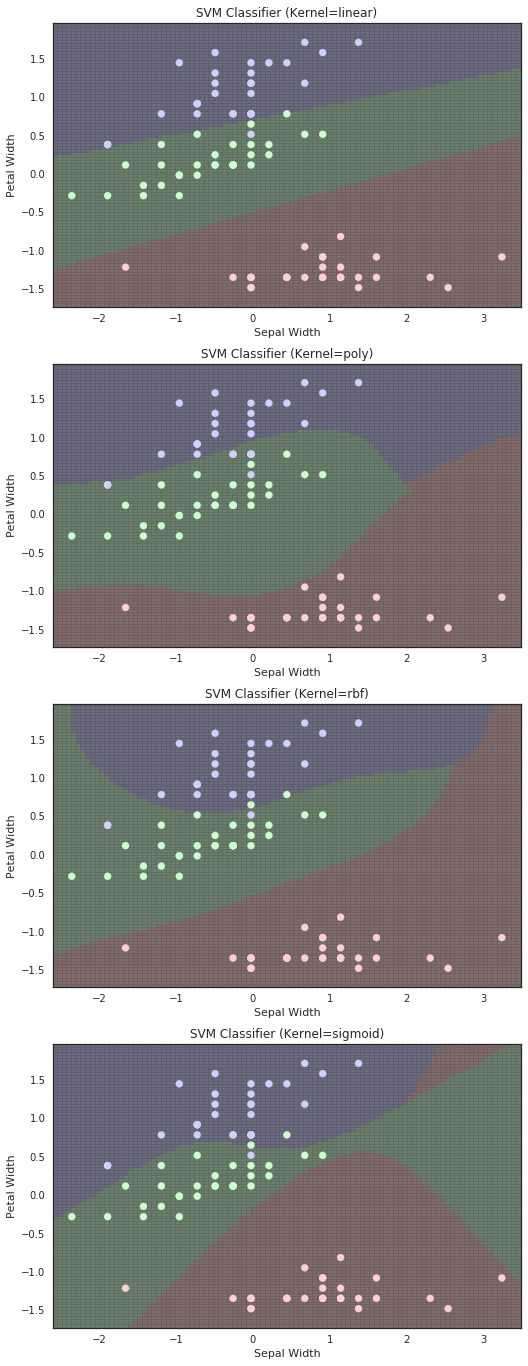

In [10]:
# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10,24), nrows=4, ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, kf in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
    
    # Now train our model
    svc.set_params(kernel = kf, random_state=23)
    
    # Now train our model
    svc.fit(n_data[:,:2], n_data[:,2])
    
    # Compute and display accuracy score
    score = 100.0 * svc.score(t_data[:,:2], t_data[:,2])
    print(f"SVM (Kernel={kf}) accuracy = {score:5.1f}%")    
    
    # Predict for mesh grid
    z = svc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'SVM Classifier (Kernel={kf})')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we employed different kernel functions to explore how the decision surfaces changed. These kernel functions accept specific hyperparameters, which alter how the kernel transformation is performed. For example, the `degree` hyperparameter specifies the degree of the polynomial transformation (default is three), `gamma` is a kernel coefficient for the `rbf`, `poly`, and `sigmoid` kernels, and `coef0` i an independent term for the `poly` and `sigmoid` kernels.

Now that you have run the notebook once, go back and make the following changes to see how the results change.

1. Change the `degree` hyperparameter for the polynomial kernel, both higher and lower than the default value of three.
2. Change the `gamma` hyperparameter to values between 0.5 and 5.0.
3. Change the `coef0` hyperparameter to values between 1 and 10.

How does the decision surface change as these hyperparameters change? Does the accuracy improve or get worse?

-----

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now transition to a more complex data set, the adult data from the UCI machine learning repository. These data are fully documented online at the UCI website, and were used and discussed originally in the Introduction to Decision Tree notebook. The following two Code cells first define the local filename where we wish to store these data, and if the file does not yet exist, uses the `wget` commend to grab these data from the UCI repository.

-----

[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult
[idt]: intro2dt.ipynb

In [11]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/adult.data'

In [12]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

We now have the data stored locally, and can proceed to read the data into a DataFrame so we can process it appropriately before applying support vector classification. Once we have read the data into a DataFrame by using the `read_csv` method, we can create a binary label feature to indicate people with salaries below \$50K, or class 0, and people with salaries above \$50K, or class 1. Once this step is done, we drop the original feature, and extract those features that we will use.

For this classification task, we will start by selecting six categorical features and five numerical features. We extract these different sets of features form the original DataFrame and create a new `features` DataFrame to hold the features of interest. We end the following Code cell by randomly sampling five instances from our new data set.

-----

In [13]:
# Adult data archived at UCI ML Repository
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data from URL return Pandas
adult_data = pd.read_csv(data_url, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

# Exract categorical features
categorical = ['Education', 'Workclass', 'Race', 'Sex', 'Occupation', 'Relationship']
cat_data = pd.get_dummies(adult_data[categorical])

# Extract numerical features
numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 'CapitalGain', 'CapitalLoss']
num_data = adult_data[numerical]

# Extract labels

labels = adult_data['Label']

# Create feature DataFrame
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Relationship_ Husband,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife
1640,52,9,38,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
29651,24,9,50,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
29718,33,15,40,0,1887,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
23661,70,11,50,9386,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
27800,25,10,35,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

With the data now loaded into a DataFrame in our notebook, we can move on to creating our training and testing data sets, and employing support vector classification.

-----

In [14]:
from sklearn.model_selection import train_test_split

frac = 0.4
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

----

With our data now divided into training and testing, we can apply SVC to classify these data. In the following Code cell, we create a `LinearSVC` estimator from the `svm` module in the scikit-learn library. We use this estimator, instead of the standard `SVC` estimator, primarily for performance reasons. This training data is actually rather large, consisting of nearly 20,000 instances each with 58 features. To enable fast classification, we use a linear kernel, which is the only option with the `LinearSVC`. This estimator in scikit-learn also employs a fast-underlying algorithm implementation since there are fewer options. 

With default hyperparameters, this estimator achieves reasonable performance. But as the classification report demonstrates, the positive class, which is higher salary people, has  fewer instances along with degraded performance. In fact, our recall for this target is only 0.21, which is very low and indicates we are misclassifying most of the actual high salary instances. If our goal is to find these individuals in order to target them as potential customers, this would be a major problem. We will address this in the next section on _unbalanced classes_.

-----

In [15]:
from sklearn.svm import LinearSVC

adult_model = LinearSVC(random_state=23)
adult_model = adult_model.fit(d_train, l_train)

print('Linear SVC Score = {:.1%}'.format(adult_model.score(d_test, l_test)))

Linear SVC Score = 79.8%


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * accuracy_score(l_test, predicted)
print(f'Support Vector Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    classification_report(l_test, predicted)))

Support Vector Classification [Adult Data] Score = 79.8%

Classification Report:
              precision    recall  f1-score   support

          0       0.79      0.99      0.88      9811
          1       0.89      0.21      0.33      3214

avg / total       0.82      0.80      0.75     13025




-----

[[Back to TOC]](#Table-of-Contents)

### Support Vector Classification: Unbalanced Classes

So far, we have dealt with classification tasks where we have sufficient examples of all classes in our training data set. Sometimes, however, we are given data sets that are unbalanced, where one or more classes are underrepresented in the training data. In general, this can become very problematic, and can lead to [subtle biases][gp] that might be difficult to find until it is too late.

A classic example where unbalanced classes can arise is in fraud detection. For a company to remain in business, fraud should be a rare event, ideally well below one percent. Imagine you have been given a set of transactions, and your task is to predict fraud. In this case you might have 9,900 negative examples, and only 100 positive examples. If we simply want to achieve the highest performance model, we can always predict **no fraud** and our model will be accurate 99% of the time! Clearly this is not appropriate.

This naive approach, known as the zero model, is to always predict the class with the most training labels. While uninformative as a model, it can provide a useful baseline for performance. In the following Code cell, we compute the zero model performance, which interestingly enough is close to our original support vector classification algorithm's results on these data.

-----
[gp]: https://www.usatoday.com/story/tech/2015/07/01/google-apologizes-after-photos-identify-black-people-as-gorillas/29567465/

In [17]:
labels = adult_data['Label']
print(f'{np.sum(labels==0):d} low salaries')
print(f'{np.sum(labels==1):d} high salaries')

zm = float(np.sum(labels==0)) / (np.sum(labels==0) + np.sum(labels==1))

print(f'Zero Model Performance = {100.0 * zm:4.2f}%')

24720 low salaries
7841 high salaries
Zero Model Performance = 75.92%


-----

Fortunately, the support vector classification estimator in the scikit-learn library has a hyperparameter called `class_weight` that can be used to modify how the estimator is fit to the training data. By default, this value informs the estimator that all class weights are uniform. Alternatively, we can set this hyperparameter to `balanced`, which computes the class weights directly from the training data, by using their relative frequencies, and uses this to determine the optimal estimator. Other approaches are also possible, but require additional work that is beyond the scope of this notebook.

In the following two Code cells, we create a new SVC estimator by specifying that balanced class weights should be computed and used during the fitting process. The resulting score has improved significantly, and the classification report demonstrates that the recall of the positive class has nearly doubled over the uniform weighting scheme originally used. In general, this is often a very useful technique that you can use to improve the performance of a classification algorithm, especially when the classes in your training data are unbalanced.

-----

In [18]:
from sklearn.svm import LinearSVC

adult_model = LinearSVC(class_weight='balanced', random_state=23)

adult_model = adult_model.fit(d_train, l_train)

print('Linear SVC Score = {:.1%}'.format(adult_model.score(d_test, l_test)))

Linear SVC Score = 82.9%


In [19]:
# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    classification_report(l_test, predicted)))

Decision Tree Classification [Adult Data] Score = 82.9%

Classification Report:
              precision    recall  f1-score   support

          0       0.83      0.97      0.89      9811
          1       0.80      0.41      0.54      3214

avg / total       0.83      0.83      0.81     13025




-----

[[Back to TOC]](#Table-of-Contents)

## The ROC Curve and AUC

While the standard performance metrics are useful for a standard classification task, many algorithms now generate a probabilistic classification. As a result, we need a method to not only compare different estimators, but determine the optimal threshold for an estimator. To support this decision, we employ the [receiver operating characteristic (ROC ) curve][wroc]. Originally developed during World War Two to predict the performance of an individual using a radar system, the ROC curve displays the relationship between the number of false positives (along the x-axis) and true positives (along the y-axis) as a function of probability threshold.

The ROC curve starts at the lower left, where nothing has been classified. From here the estimator is used to determine the true and false positives for very high probability thresholds. At this point, the curve should shoot upward from the lower left, wince we expect a good classifier (and what other type of classifier would we build) performs well at high threshold. In general, as the probability threshold is lowered, we will begin to predict more false positives, and thus the curve will shift to the right.

To generate a ROC curve, we need to create arrays of false and true positives at different probability thresholds. Fortunately, the scikit-learn library provides a `roc_curve` method, that given the true labels and probabilistic classifications from either a `decision_function` method or a `predict_proba` method, will compute a set of probability thresholds, along with corresponding true and false positive values at these thresholds.

Given an ROC curve, another performance metric that can be measured is the _area under the curve_ or AUC. In an ideal case this metric has the value of one, or perfect classification, and a random classification has the value of 0.5. This metric can provide a useful comparison between different estimators on the same data. The scikit-learn library provides an `auc` method that will compute this quantity from two arrays holding the true and false positive rates.

-----

[wroc]: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import auc

# Grab positive class probability
y_score_svm = adult_model.decision_function(d_test)

# Compute ROC curve and ROC area

fpr_svm, tpr_svm, thresholds = roc_curve(l_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

-----

With these data, we can plot the ROC curve for our SVM classification estimator. Before doing so, however, in the next two Code cells, we create, fit, and compute the roc curve data for a logistic regression estimator and a decision tree estimator. The third Code cell below compares the performance of these three estimators. Note that we have not optimized any of these estimators, we simply will use them to compare and interpret ROC curves.

-----

In [21]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=23)
lr_model = lr_model.fit(d_train, l_train)

# Grab positive class probability
y_score_lr = lr_model.decision_function(d_test)

# Compute ROC curve and ROC area
fpr_lr, tpr_lr, thresholds = roc_curve(l_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=23)
dt_model = dt_model.fit(d_train, l_train)

# Grab positive class probability
y_score_dt = dt_model.predict_proba(d_test)[:, 1]

# Compute ROC curve and ROC area
fpr_dt, tpr_dt, thresholds = roc_curve(l_test, y_score_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

In [23]:
print('SVM Model Score = {:.1%}'.format(adult_model.score(d_test, l_test)))
print('LR Model Score = {:.1%}'.format(lr_model.score(d_test, l_test)))
print('DT Model Score = {:.1%}'.format(dt_model.score(d_test, l_test)))

SVM Model Score = 82.9%
LR Model Score = 84.9%
DT Model Score = 81.7%


-----

With the different false positive and true positive arrays corresponding to the three different estimators, we can now plot the ROC curves for these three estimators, along with the random baseline and perfect classifier ROC curves. Since an ROC curve is simply a plot of the false positive rate versus the true positive rate for different probability thresholds, the following Code cell is straightforward. We also display the area under the curve, which provides a single metric that can be used to compare classification estimators.

When interpreting a ROC curve, the goal is to approximate as closely as possible to the perfect classifier, which reaches 100% true positive at zero false positive. On the other hand, an estimator should perform better than the baseline, which is essentially a random guess. As the figure below demonstrates, the logistic regression and support vector classification estimators perform very well. The decision tree performs less well, but still better than the baseline. Looking at this curve, it should be clear that by optimizing the hyperparameters for these estimators, we should be able to reach very high accuracy on this classification task.


-----

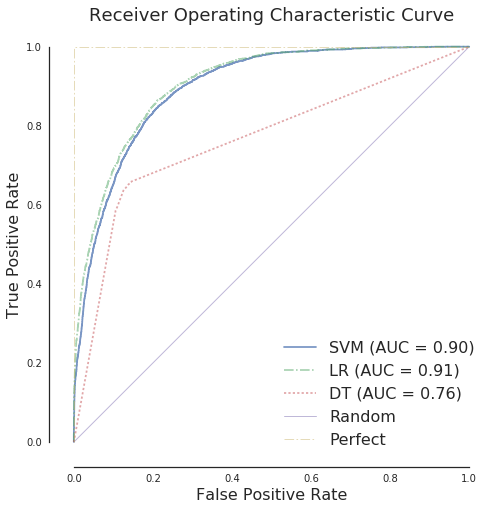

In [24]:
# Make the plots
fig, ax = plt.subplots(figsize=(8, 8))

# Plot data and model

ax.plot(fpr_svm, tpr_svm, alpha = 0.75, linestyle='-',
        label=f'SVM (AUC = {roc_auc_svm:4.2f})')

ax.plot(fpr_lr, tpr_lr, alpha = 0.5, linestyle='-.',
        label=f'LR (AUC = {roc_auc_lr:4.2f})')

ax.plot(fpr_dt, tpr_dt, alpha = 0.5, linestyle=':',
        label=f'DT (AUC = {roc_auc_dt:4.2f})')

ax.plot([0, 1], [0, 1], alpha = 0.5, 
        lw=1, linestyle='-', label='Random')
ax.plot([0, 0, 1], [0, 1, 1], alpha = 0.5, 
        lw=1, linestyle='-.', label='Perfect')

# Decorate plot appropriately
ax.set_title('Receiver Operating Characteristic Curve', fontsize=18)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.legend(loc=4, fontsize=16)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## The Gain and Lift Charts

While the ROC curve provides a lot of detail into the performance of an estimator, and also allows the performance of different estimators to be compared, we will sometimes want a different performance metric. For example, we may not have a sufficient budget to target all customers on which we have data. Thus, we can build a classifier to estimate which of our customers makes more than fifty thousand dollars a year. However, even this subset might be too large. What we really want is a way to select those instances from our classified data that we believe have the highest likelihood of being in our target category. Two charts that are useful to accomplish this goal are the _gain chart_ and the related [_lift chart_][wld].

In the following Code cell, we define a function `compute_gain`, since the scikit learn library does not provide this by default. Note, that you are not expected to understand this function, it is optional. Essentially this function works by using the provided, trained estimator to compute probabilistic classifications for the test data, selecting the positive classifications, and sorting the results. We accumulate the cumulative scores and generate an array that enumerates the instances. Note, this is slightly different than many gain or lift computations since we do not bin the data, for example into deciles. Instead each instance is considered a small subset of the total test data. We treat the baseline model as a constant model, as in the ROC curve.

The ratio between an individual gain curve and the baseline provides a measure of the relative performance of an estimator to the baseline. Since this measurement is sorted by estimator performance, we can determine what fraction of a classified data set we might want to target for a specific program.

A classic example of where a lift chart is often used is in marketing. If we have a limited budget, we want to optimally target customers who will respond positively to ads or a marketing campaign. As a result, we would build a model and compute lift chart. This chart can be used to infer a cutoff point in the sample, above which we have the highest likelihood of a positive response. This will allow us to target customers optimally given a limited budget.

An alternative example is preventing customer churn, which is where customers migrate from one company to another. We can use a classifier to predict how likely a customer is to churn. With a lift chart, we can identify those customers most likely to churn and focus our limited retention budget on keeping them with our company.

-----

[wld]: https://en.wikipedia.org/wiki/Lift_(data_mining)

In [25]:
# Understanding this function is OPTIONAL
#
# Function computes the gain from a given scikit-learn estimator
# and the test data features and labels
# Note, we use all data, no deciles.
# Note, we assume a binary classification

def compute_gain(mdl, d_test, l_test):
    
    # Compute the posterior probabilities from test labels.
    # Membership is in matrix of form: [Neg, Pos]
    
    if hasattr(mdl, 'decision_function'):
        # If the estimator has a decision_function method,
        # we call it, and use the result as a 'positive'
        # label for computing the gain.
        prbas = mdl.decision_function(d_test)
        pos_score = prbas

    else: # Use `predict_proba`
        
        # Otherwise, we assume the estimator has the 
        # predit_proba method and use it to extract
        # the second columnd, which is the 'positive'
        # labels we need to compute the gain.
        prbas = mdl.predict_proba(d_test)
        pos_score = prbas[:,1]

    # Generate class membership
    # Membership is in matrix of form: [Neg, Pos]
    clm = pd.get_dummies(l_test).as_matrix()
    
    # Second column indicates 'positive' label
    pos_lbl = clm[:,1]
    
    # Compute total number of 'positive' labels
    n_pos_lbl = np.sum(pos_lbl)
    
    # Generate sorted (ascending) index array by 'positive' score
    idx = np.argsort(pos_score) 
    
    # Now sort 'positive' labels by the sorted index
    sort_pos = pos_lbl[idx[::-1]]
    
    # Compute cumulative sum
    cum_sum_pos = np.cumsum(sort_pos)
    
    # lift is the ratio of cumulative improvement to all data 
    lift = cum_sum_pos/n_pos_lbl
    
    # Number of test instances
    num_test = l_test.shape[0]
    
    # Amount of test data included as a percentage of total
    tst_pcnt = np.arange(1,num_test + 1, 1) /num_test
    
    return tst_pcnt, lift

-----

With the previous function (understanding this function is optional), we can compute the gain for a given classification model and test data set. The output of this function allows different estimators to be compared, both with each other, and a baseline model. In addition this comparison can be performed at different fractions of the overall test data set. 

Recall, that since we sort the results, the gain chart starts by showing the best performing test data, gradually converging to the baseline. The following Code cell plots gain curves for the three different classification estimators that we created and compared in the ROC curve analysis earlier in this notebook. In the following gain chart, we see similar behavior, namely that the logistic regression and support vector regression estimators perform very well, with the decision tree estimator performing slightly worse.

-----

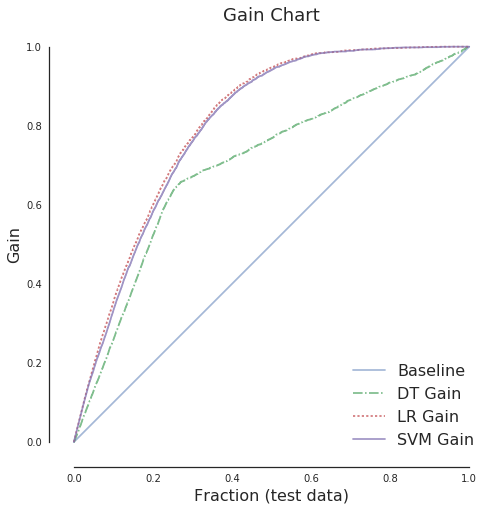

In [26]:
# Compute gains for different estimators
xsvm, gain_svm = compute_gain(adult_model, d_test, l_test)
xlr, gain_lr = compute_gain(lr_model, d_test, l_test)
xdt, gain_dt = compute_gain(dt_model, d_test, l_test)

# Make the plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(xlr, xlr, alpha = 0.5, linestyle='-',
        label=f'Baseline')

ax.plot(xdt, gain_dt, alpha = 0.75, linestyle='-.',
        label=f'DT Gain')

ax.plot(xlr, gain_lr, alpha = 0.75, linestyle=':',
        label=f'LR Gain')

ax.plot(xsvm, gain_svm, alpha = 0.75, linestyle='-',
        label=f'SVM Gain')

# Decorate plot appropriately
ax.set_title('Gain Chart', fontsize=18)
ax.set_xlabel('Fraction (test data)', fontsize=16)
ax.set_ylabel('Gain', fontsize=16)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_aspect('equal')
ax.legend(loc=4, fontsize=16)
sns.despine(offset=5, trim=True)

-----

In the following Code cell, we first compute the lift curve for our three different classification estimators. In this case, the lift is simply the gain for the estimator divided by the baseline response. With these values computed, we next plot the three lift curves for comparison, along with a baseline performance, which is always unity. To [interpret the lift curve][23], recall that the value of the lift curve at any point indicates the relative improvement of our model over random. 

From this curve, we can see that our default logistic regression and support vector classification algorithms both perform very well. But more importantly, if this classification was being used to target customers, we can optimize our results and use less money by targeting those customers who fall to the left in this chart. In some cases, you may see these curves converted into a profit curve, where the value of the prediction is included. In this example, we might assume a cost per targeted ad to convert the lift curve into a cost curve, which would allow us to determine how many (and who) of the individuals we should target given a budget. However, these types of curves are generally domain specific, so we do not present them in this notebook.

-----

[23]: http://blog.datalifebalance.com/lift-charts-a-data-scientists-secret-weapon/

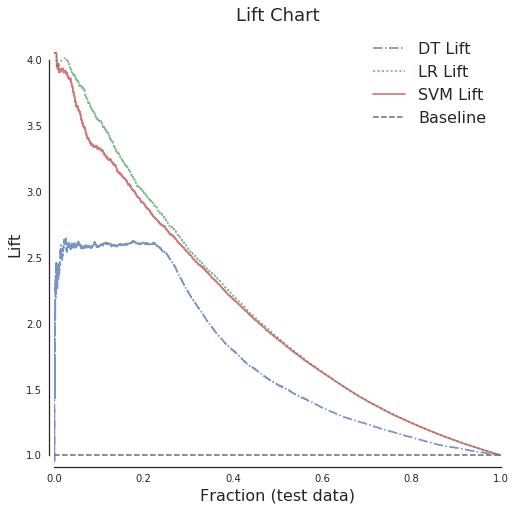

In [27]:
# Compute lift by normalzing gains to baseline
lift_lr = gain_lr / xlr
lift_dt = gain_dt / xdt
lift_svm = gain_svm / xsvm

# Make the plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(xdt, lift_dt, alpha = 0.75, linestyle='-.',
        label=f'DT Lift')

ax.plot(xlr, lift_lr, alpha = 0.75, linestyle=':',
        label=f'LR Lift')

ax.plot(xsvm, lift_svm, alpha = 0.75, linestyle='-',
        label=f'SVM Lift')

ax.hlines(1.0, 0.0, 1.0, alpha = 0.5, linestyle='--',
        label=f'Baseline')

# Decorate plot appropriately
ax.set_title('Lift Chart', fontsize=18)
ax.set_xlabel('Fraction (test data)', fontsize=16)
ax.set_ylabel('Lift', fontsize=16)
ax.set_xlim(0, 1)
ax.set_ylim(0.95, 4.25)
ax.legend(loc=1, fontsize=16)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Support Vector Machine: Regression

To this point, we have only applied the support vector machine algorithm to classification tasks. This algorithm can also be applied to regression tasks by using hyperplanes to model the data distribution. Basically, this algorithm works on regression problems by mapping the training data into a high dimensional space, which might involve a non-linear kernel, and performing something akin to linear regression on the data in this higher dimensional space. Recall that for best performance, SVMs require the data be normalized prior to use.

To perform support vector regression, or SVR, we will use the `SVR` estimator in the `svm` module in the scikit-learn library. This estimator accepts a very similar list of hyperparameters to the `SVC` estimator discussed earlier in this notebook. One of the few important additions is the `epsilon` hyperparameter, which is used in the cost function that is minimized when constructing the SVR model. This term essentially defines a _tune_ around the best fit model wherein data inside the tube are ignored, since they are _close_ to the model, and data outside are used to modify the final predictive model.

In the rest of this section, we demonstrate how to perform SVR on a complex data set, in this case the automotive fuel prediction data, also used in previous notebooks. Note that in the following example, we have not normalized the numerical features. While this obviously can affect performance, we leave that as a student exercise.



-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

To demonstrate support vector regression, we will use the automobile fuel efficiency data set from the UCI machine learning repository. We first introduced these data in the Introduction to Decision Tree notebook. For more information on these data, refer to the [online documentation][od] at the UCI website.

In the following Code cells, we load these data into our notebook, construct an SVR predictive model, and evaluate its performance. The first two Code cells first construct the full path to the local copy of this data. If the file does not exist, we grab it from the UCI repository by using the `wget` command.

----

[idt]: intro2dt.ipynb
[od]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [28]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/data/auto-mpg.data'

In [29]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


-----

With the data file now available locally, we can read this data into our notebook as a pandas DataFrame. The columns are delimited by whitespace, so we indicate this to the `read_csv` method and explicitly provide the column names. With this DataFrame, we finish the following Code cell by dividing these data into training and testing sets.

-----

In [30]:
import patsy as pts 

# Feature names
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Read in the DataFrame, features are delimited by whitespace
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)

# Create feature and label DataFrames using formula-based interface
y, x = pts.dmatrices('MPG ~ C(Cylinders) + Displacement + Horsepower + ' +
                     'Weight + Acceleration + C(Year) + C(Origin)', 
                     data=auto_data, return_type='dataframe')

# Split data into training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

-----

With these data now loaded into a DataFrame and split into training and testing samples, we can create a regression model by using the `SVR` estimator in the `svm` module in the scikit-learn library. First, we create our estimator, in this case we simply use the default hyperparameters. Next, we fit the model to our training data. Finally, we compute a regression score, which by default is $R^2$, or the coefficient of determination. Our computed score is not great, for reference, a perfect model would have a score of one, and a constant model that ignored the feature values would have a score of zero. However, a specific $R^2$ score can be difficult to interpret in general since it cannot be directly compared to the input features or target labels. However, for a first application of support vector regression, the value is reasonable. 

The second Code cell computes and displays other metrics, which in this case provide more insight into our performance. For example, the mean and median absolute errors indicate that we predict the miles per gallon for an automobile in the test data set within about 5.5 miles per gallon. Another technique for improving a regression is to use residual plots to quantify which features provide the most (and least) predictive power.

-----

In [31]:
from sklearn.svm import SVR

# Create Regressor with default properties
auto_model = SVR()

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print(f'Regression Score = {auto_model.score(ind_test, dep_test):5.3f}')

Regression Score = 0.123


In [32]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 5.65
Mean Squared Error    = 47.28
Median Absolute Error = 5.34
R^2 Score             = 0.123
Explained Variance    = 0.123


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used support vector regression to model the fuel efficiency of automobiles. Try to improve the results by making the following changes. As you try these tasks, try to understand what has changed and if the change is good or bad.

2. Iteratively remove one or more of the categorical features from the training data.
3. Change the fraction of data held out for testing.
5. Try using a different kernel function, the default is `rbf`. 
4. Change the kernel-specific hyperparameters such as `gamma`, `degree`, and `coef0`.

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. A [beginners guide][1] to support vector machines
1. An [introduction to machine learning][2] with support vector machines
32. A readable [article][44] that discusses ROC curves, AUC, and Lift charts.
23. A concise [online explanation][55] of gain and lift charts

-----

[1]: https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners
[2]: http://www.ritchieng.com/machine-learning-svms/
[44]: http://www.stat-d.si/mz/mz3.1/vuk.pdf
[55]: http://www.saedsayad.com/model_evaluation_c.htm

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode